In [245]:
import datasets
import pandas as pd
import matplotlib.pyplot as plt

I have uploaded the datasets here: [registrations](https://huggingface.co/datasets/baber/NYPL_entries) and [renewals](https://huggingface.co/datasets/baber/cce-renewals). The Registrations are subset to < 1964. Further column details in the dataset links.

In [246]:
# load the datasets
reg = datasets.load_dataset("baber/NYPL_entries")["train"].to_pandas().iloc[:, :-5]
ren = datasets.load_dataset("baber/cce-renewals")["train"].to_pandas().drop(["see_also_reg", "notes", "new_matter", "see_also_ren", "see_also_reg"], axis=1)

In [225]:
reg.head()

,year,volume,part,page,id,regnum,authorName,title,pubName,pubPlace,date,regDate,regNum
0,1944,41,1,125,FC10B2ED-7454-1014-804D-AD6D08A5DF13,A181780,Abrams (Talbert),Essentials of aerial surveying and photo inter...,"McGraw-Hill book co., inc.",New York,1944-07-17,"July 17, 1944",A 181780
1,1944,41,1,125,FC10C2AA-7454-1014-804D-AD6D08A5DF13,A181778,Akers (Susan Grey),Simple library cataloging,Amer. library assn.,Chicago,1944-06-29,"June 29, 1944",A 181778
2,1944,41,1,125,FC10C53D-7454-1014-804D-AD6D08A5DF13,A181622,Almack (John C.),Painted pony,Wallace Hebberd,"Santa Barbara, Calif.",1944-07-01,"July 1, 1944",A 181622
3,1944,41,1,125,FC10C77B-7454-1014-804D-AD6D08A5DF13,A181549,Altenburg (Clarence E.),Modern conquistador in South America,Christopher pub. house,Boston,1944-06-24,"June 24, 1944",A 181549
4,1944,41,1,125,FC10C9F9-7454-1014-804D-AD6D08A5DF13,A181542,Altrocchi (Rudolph),Sleuthing in the stacks,President & fellows of Harvard college,"Cambridge, Mass.",1944-06-23,"June 23, 1944",A 181542


In [226]:
ren.head()

,id,entry_id,title,rdat,full_text,claimants,oreg,volume,odat,page,author,number,part
0,R59299,a4fa4317-a991-58a3-8711-16411fb30eb9,"HIS CHILDREN'S CHILDREN (In Cosmopolitan, July...",1950-03-06,"HIS CHILDREN'S CHILDREN, by Arthur C. Train. (...",Helen C. Train|W,B553617,4.0,1922-12-10,23.0,Arthur C. Train.,1.0,14A
1,R60397,ab74c10c-5dc0-5c44-b88a-0833652191bf,"HIS SOUL, a farce in one act (French's interna...",1950-04-04,"HIS SOUL, a farce in one act, by Eleanor Maud ...",Effingham Crane|E,D62776,4.0,1922-10-31,23.0,Eleanor Maud Crane.,1.0,14A
2,R59546,5ce3fe65-7a4e-509f-a09a-4447035448f9,HIS SOUL GOES MARCHING ON,1950-03-14,"HIS SOUL GOES MARCHING ON, by Mary Raymond Shi...",Paul Shipman Andrews|C,A659413,4.0,1922-03-24,23.0,Mary Raymond Shipman Andrews.,1.0,14A
3,R61282,ee4ab3d8-9ce7-5721-877e-428f58e00740,"HIS THIRD MASTER, by Max Brand [pseud. of Fred...",1950-04-21,"HIS THIRD MASTER, by Max Brand [pseud. of Fred...",Dorothy Faust|W,B528460,4.0,1922-06-01,23.0,None,1.0,14A
4,R61283,ee4ab3d8-9ce7-5721-877e-428f58e00740,"HIS THIRD MASTER, by Max Brand [pseud. of Fred...",1950-04-21,"HIS THIRD MASTER, by Max Brand [pseud. of Fred...",Dorothy Faust|W,B529064,4.0,1922-06-08,23.0,None,1.0,14A


We mainly care about the registration date and the (non-unique) registration number. They have standardized and non-standardized columns in the registrations dataset.

In [247]:
reg = reg[["regnum", "regNum" ,"date", "regDate", "id", "year"]]
reg["date"] = pd.to_datetime(reg["date"], errors="coerce")
reg = reg[reg['date'].dt.year < 1964]
ren = ren[["oreg", "odat" ,"rdat", "entry_id"]].rename(columns={"oreg": "regnum", "odat": "date"})
ren["date"] = pd.to_datetime(ren["date"], errors="coerce")

Some basic stats

In [248]:
print(f"Total entries: {len(reg)}")
print(f"Total n/a entries")
print(reg.isnull().sum())

Total entries: 893834
Total n/a entries
regnum     31
regNum     40
date        0
regDate     0
id          0
year        0
dtype: int64


In [249]:
print(f"Total entries: {len(ren)}")
print(f"Total n/a entries")
print(ren.isnull().sum())

Total entries: 445386
Total n/a entries
regnum      1719
date        1714
rdat        1693
entry_id       0
dtype: int64


Remove the n/a for now and remove duplicates (date + regnum)

In [251]:
reg_na = reg[reg[["regnum", "date"]].isna().any(axis=1)]
ren_na = ren[ren[["regnum", "date"]].isna().any(axis=1)]
reg.dropna(subset=["regnum", "date"], inplace=True)
ren.dropna(subset=["regnum", "date"], inplace=True)
reg.drop_duplicates(subset=["regnum", "date", "id"], inplace=True)
ren.drop_duplicates(subset=["regnum", "date", "entry_id"], inplace=True)

In [252]:
print(f"Registrations after removing n/a: {len(reg):,}")
print(f"Renewals after removing n/a: {len(ren):,}")

Registrations after removing n/a: 893,803
Renewals after removing n/a: 443,202


We only consider registration numbers starting with A (but not AF: foreign, AI: interim) as that's for books from what I can tell. 
TODO confirm

In [253]:
foreign = reg[reg['regnum'].str.startswith('AF')]
print(f"Foreign entries: {len(foreign):,}")
reg = reg[reg['regnum'].str.startswith('A') & ~reg['regnum'].str.startswith('AF') & ~reg['regnum'].str.startswith('AI')]
ren = ren[reg['regnum'].str.startswith('A') & ~ren['regnum'].str.startswith('AF') & ~ren['regnum'].str.startswith('AI')]

Foreign entries: 110,121


/var/folders/jk/7srv9d5d0wvcbz8z_t3yjz_m0000gn/T/ipykernel_98199/630209938.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ren = ren[reg['regnum'].str.startswith('A') & ~ren['regnum'].str.startswith('AF') & ~ren['regnum'].str.startswith('AI')]


In [254]:
print(f"Total registrations: {len(reg):,}")
print(f"Total renewals: {len(ren):,}")


Total registrations: 751,305
Total renewals: 351,651


In [255]:
# match all rows with registration date AND registration number
mask = reg.set_index(['date', "regnum"]).index.isin(ren.set_index(['date', "regnum"]).index)
df1_filtered = reg[~mask]
print(f"Total Matched: {(total_matched := len(reg) - len(df1_filtered)):,}")
print(f"% registrations matched: {(percentage_matched := (total_matched / len(reg)) * 100):.2f}%")
print(f"% Renewals Matched: {(percentage_renewals_matched := (total_matched / len(ren)) * 100):.2f}%")
print(f"Renewals Remaining: {(renewals_remaining := len(ren) - total_matched):,}")
print(f"Registrations Remaining: {len(reg) - total_matched:,}")

Total Matched: 125,328
% registrations matched: 16.68%
% Renewals Matched: 35.64%
Renewals Remaining: 226,323
Registrations Remaining: 625,977


/var/folders/jk/7srv9d5d0wvcbz8z_t3yjz_m0000gn/T/ipykernel_98199/1857446399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg['_year'] = pd.to_datetime(reg['date']).dt.year


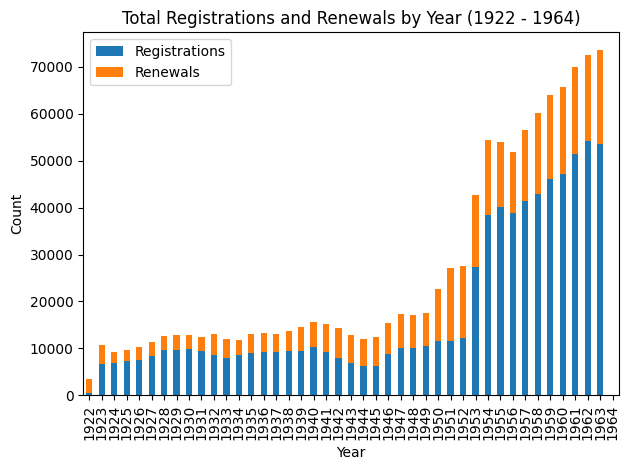

In [256]:
# Filter the data to include only years from 1922 to 1964
reg['_year'] = pd.to_datetime(reg['date']).dt.year
ren['_year'] = pd.to_datetime(ren['date']).dt.year

reg_filtered = reg[reg['_year'].between(1922, 1964)]
ren_filtered = ren[ren['_year'].between(1922, 1964)]

# Group by year and count
reg_counts = reg_filtered.groupby('_year').size()
ren_counts = ren_filtered.groupby('_year').size()

# Merge the two series into a DataFrame
yearly_data = pd.DataFrame({'Registrations': reg_counts, 'Renewals': ren_counts}).fillna(0)

# Plotting the stacked bar chart
yearly_data.plot(kind='bar', stacked=True)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Total Registrations and Renewals by Year (1922 - 1964)')

# Apply tight layout
plt.tight_layout()

# Show the plot
plt.show()

/var/folders/jk/7srv9d5d0wvcbz8z_t3yjz_m0000gn/T/ipykernel_98199/3358614475.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmatched_renewals['date'] = pd.to_datetime(unmatched_renewals['date'])
/var/folders/jk/7srv9d5d0wvcbz8z_t3yjz_m0000gn/T/ipykernel_98199/3358614475.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmatched_renewals['year'] = unmatched_renewals['date'].dt.year


Text(0.5, 1.0, 'Unmatched Renewals by Registration date (1922 - 1964)')

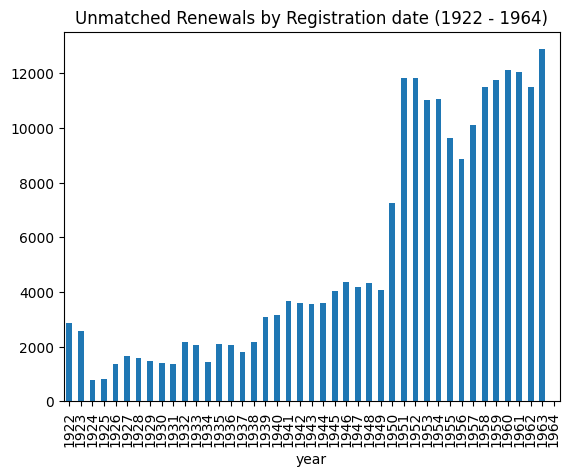

In [257]:
# Create a mask for 'ren'
mask_ren = ren.set_index(['date', "regnum"]).index.isin(reg.set_index(['date', "regnum"]).index)
# Filtering unmatched renewals in 'ren'
unmatched_renewals = ren[~mask_ren]
# Ensure 'date' is a datetime object
unmatched_renewals['date'] = pd.to_datetime(unmatched_renewals['date'])
# Extracting year
unmatched_renewals['year'] = unmatched_renewals['date'].dt.year
# Filtering for years between 1922 and 1964
unmatched_renewals_filtered = unmatched_renewals[unmatched_renewals['year'].between(1922, 1964)]
# Group by year and count
unmatched_renewals_by_year = unmatched_renewals_filtered.groupby('year').size()
# Plotting
unmatched_renewals_by_year.plot(kind='bar')
plt.title('Unmatched Renewals by Registration date (1922 - 1964)')


In [265]:
# merge the unmatched_renewals and registrations to the original to stitch back all the columns
reg = datasets.load_dataset("baber/NYPL_entries")["train"].to_pandas().iloc[:, :-5].drop_duplicates(["id"])
ren = datasets.load_dataset("baber/cce-renewals")["train"].to_pandas().drop(["see_also_reg", "notes", "new_matter", "see_also_ren", "see_also_reg"], axis=1).drop_duplicates(["entry_id"])

ren = unmatched_renewals.merge(ren, how="left", on="entry_id")
reg = df1_filtered.merge(reg, how="left", on="id")
# get len (includes n/a)
print(f"Registrations remaining: {len(reg)}")
print(f"Renewals remaining: {len(ren)}")


Registrations remaining: 625977
Renewals remaining: 224726
